Problem Set 1
---
Due on `2020-12-02`

This Version: `2021-1-22`

Code written by _Zhiyuan Chen_


## Simulated dataset
Below are some preparations for the simulation: 
* T=2019 means that the sample length is $(2019-2010+1)=10$, hence the total number of observations is 
$20000\times 10 = 200000$. 
* _Each individual_ $i$ should be assigned a group indicator $g$. We assume that individually are equally grouped into each groups.

* $v_{gt}$ should be group-specific, not individual specific. 
* $x_{igt}$ is i.i.d across observations

In [1]:
* Simulating the dataset
clear all
set seed 10101
qui set obs 20000 //number of individuals
g id = _n
g g = runiformint(1,60) //group number is constant over time
g theta = rnormal(0.6,0.5) //individual heterogeneity
expand 10  //expand them to be panel data








(180,000 observations created)


In [2]:
bys id: g t = _n+2009

In [3]:
*simulating v_gt
**NOTE: v_gt is group specific
set seed 10101
g u = rnormal()  //iid error term 

In [4]:
%head 15

,id,g,theta,t,u
1,1,20,.39315918,2010,.39221546
2,1,20,.39315918,2011,.84961545
3,1,20,.39315918,2012,.25830072
4,1,20,.39315918,2013,-1.7003772
5,1,20,.39315918,2014,-.33317977
6,1,20,.39315918,2015,1.2652421
7,1,20,.39315918,2016,2.8105304
8,1,20,.39315918,2017,1.5158677
9,1,20,.39315918,2018,.33430195
10,1,20,.39315918,2019,-.15467469


In [5]:
*generate initial v_g 
cap drop v
g v = .  //v_gt
set seed 10101
forv i = 1/60 {
    scalar v0 = rnormal(0, 0.1)
    qui replace v = v0 if g==`i'&t==2010
}



(200,000 missing values generated)




In [6]:
*generate epsilon by g-t pairs
cap drop epsilon
g epsilon = . // epsilon_gt
scalar sigma_e = 0.2
set seed 10101
forv i = 1/60 {
    forv j = 2010/2019 {
        scalar epst = rnormal(0, sigma_e)
        //disp(epst)
        qui replace epsilon = epst if g==`i'&t==`j'
    }
}



(200,000 missing values generated)





In [7]:
*simulating forward to get all v_gt
scalar rho = 0.8
sort id t
by id: replace v = rho*v[_n-1] + epsilon[_n-1] if _n>1& _n<=_N




(180000 real changes made)


In [8]:
scalar gamma = 0.6
scalar delta = 0.1
set seed 10101
g x = runiform() //x_igt
g dt = delta*(t-2019) //delta_t
g e = u + v
g y = gamma*x + theta + dt + e

In [9]:
save simdata.dta,replace

file simdata.dta saved


In [10]:
keep if g<=20
save simdata_sub.dta,replace


(133,460 observations deleted)

file simdata_sub.dta saved


## Monte Carlo Simulation for OLS Estimates

### Clustering at individual level

In [11]:
global N = 400
matrix Result = J($N, 5, .) //matrix to store the results
use simdata.dta,clear
set seed 12345
forv i = 1/$N {
   //disp("Processing `i'-th experiment...")
   cap drop grnum gt year treat ehat
   qui g grnum=.
   forv j = 1/60 {
        scalar r = runiform(0,1)
        qui replace grnum = r if g==`j' //group-specific random number
    }
    egen gt = cut(grnum), group(2)  //randomly assign them into two groups
    scalar treat_year = runiform(2013, 2016)
    qui{
        g year = (t>=treat_year) 
        g treat = gt*year
        xtset id t
        reg y treat x i.g i.t, vce(cluster id)
        predict ehat,r
        forv l=1/3 {
            pwcorr ehat L`l'.ehat
            scalar corr`l' = r(rho)
        }
    }
        scalar b = _b[treat]
        scalar se = _se[treat]
        matrix Result[`i',1]=(b,se,corr1,corr2,corr3)
}

In [15]:
drop _all
qui set obs $N
svmat double Result, names(c)
save Result1.dta,replace




number of observations will be reset to 400
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 400

(note: file Result1.dta not found)
file Result1.dta saved


In [40]:
clear matrix

#### (a) Histogram of estimated $\beta$

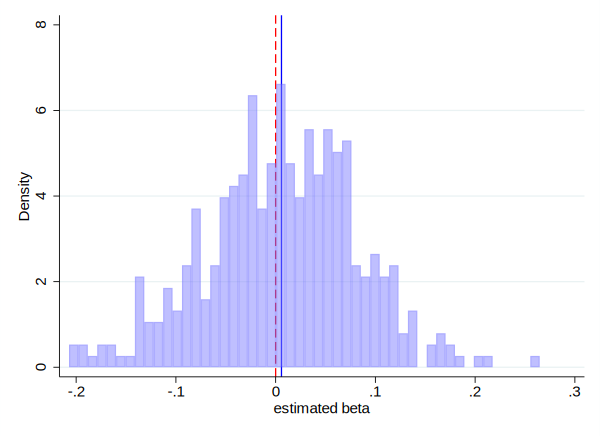

In [21]:
*(a) histogram of estimated beta
qui sum c1
local c1_mean = r(mean)c
twoway hist c1, bin(50) xline(0, lc(red) lwidth(medium) lp(dash)) xline(`c1_mean', lc(blue) lwidth(medium)) ///
                lc(blue%10) fc(blue%50) fi(inten50) xti("estimated beta") graphregion(color(white)) 

#### (b) Histograms of auto-correlations

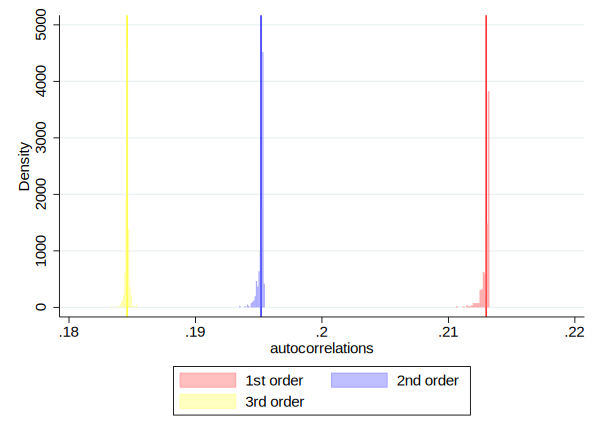

In [35]:
*(b) histograms of auto-correlations
qui sum c3
local c3_mean = r(mean)
qui sum c4
local c4_mean = r(mean)
qui sum c5
local c5_mean = r(mean)
twoway hist c3, xline(`c3_mean', lc(red) lwidth(medium)) lc(red%10) fc(red%50) fi(inten50) ///
    || hist c4, xline(`c4_mean', lc(blue) lwidth(medium)) lc(blue%10) fc(blue%50) fi(inten50)  ///
    || hist c5, xline(`c5_mean', lc(yellow) lwidth(medium)) lc(yellow%10) fc(yellow%50) fi(inten50) ///
       xti("autocorrelations")  graphregion(color(white)) legend(order(1 "1st order" 2 "2nd order" 3 "3rd order"))

#### (c) Rejection rate

In [46]:
qui g tstat = c1/c2
qui sum tstat if tstat>1.96
scalar rej_rate = r(N)/$N
disp("Rejection rate:")
disp(rej_rate)





Rejection rate:

.44


We see that the rejection rate is 44%, which is way _higher_ than the hypothetical regjection rate 5%. This means the simple OLS estimator with standard errors clustered at the individual level is problematic. 

### OLS estimator with Clustering at group-year level

In [47]:
global N = 400
matrix Result = J($N, 5, .) //matrix to store the results
use simdata.dta,clear
egen gr_t = group(g t)
set seed 12345
forv i = 1/$N {
   //disp("Processing `i'-th experiment...")
   cap drop grnum gt year treat ehat
   qui g grnum=.
   forv j = 1/60 {
        scalar r = runiform(0,1)
        qui replace grnum = r if g == `j' //group-specific random number
    }
    egen gt = cut(grnum), group(2)  //randomly assign them into two groups
    scalar treat_year = runiform(2013, 2016)
    qui{
        g year = (t>=treat_year) 
        g treat = gt*year
        xtset id t
        reg y treat x i.g i.t, vce(cluster gr_t)
        predict ehat,r
        forv l=1/3 {
            pwcorr ehat L`l'.ehat
            scalar corr`l' = r(rho)
        }
    }
        scalar b = _b[treat]
        scalar se = _se[treat]
        matrix Result[`i',1]=(b,se,corr1,corr2,corr3)
}

In [48]:
drop _all
qui set obs $N
svmat double Result, names(c)
save Result2.dta,replace




number of observations will be reset to 400
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 400

(note: file Result2.dta not found)
file Result2.dta saved


In [49]:
clear matrix

##### (a) Histogram of estimated $\beta$

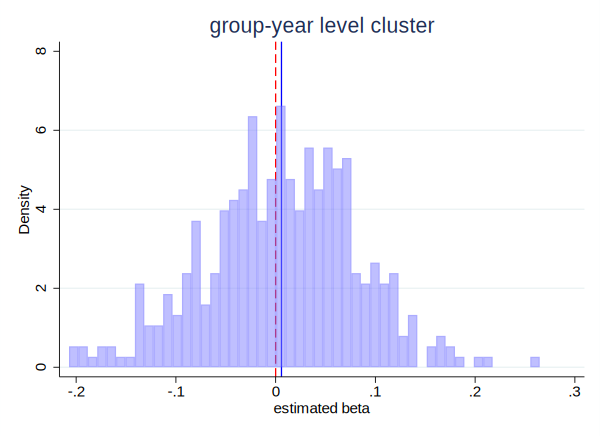

In [52]:
*(a) histogram of estimated beta
qui sum c1
local c1_mean = r(mean)
twoway hist c1, bin(50) xline(0, lc(red) lwidth(medium) lp(dash)) xline(`c1_mean', lc(blue) lwidth(medium)) ///
                lc(blue%10) fc(blue%50) fi(inten50) ///
                xti("estimated beta") title("group-year level cluster") graphregion(color(white))  //

##### (b) Histograms of auto-correlations

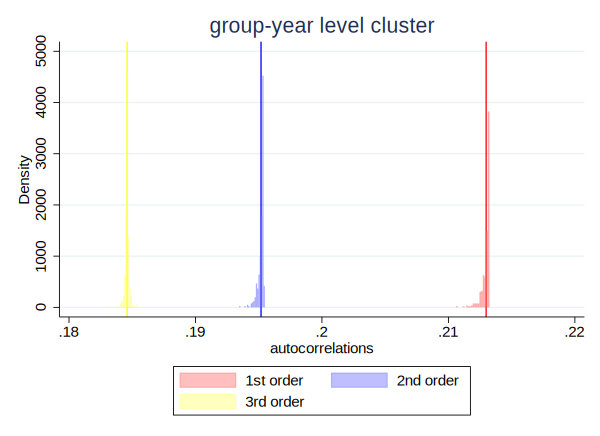

In [53]:
*(b) histograms of auto-correlations
qui sum c3
local c3_mean = r(mean)
qui sum c4
local c4_mean = r(mean)
qui sum c5
local c5_mean = r(mean)
twoway hist c3, xline(`c3_mean', lc(red) lwidth(medium)) lc(red%10) fc(red%50) fi(inten50) ///
    || hist c4, xline(`c4_mean', lc(blue) lwidth(medium)) lc(blue%10) fc(blue%50) fi(inten50)  ///
    || hist c5, xline(`c5_mean', lc(yellow) lwidth(medium)) lc(yellow%10) fc(yellow%50) fi(inten50) ///
       xti("autocorrelations")  title("group-year level cluster")  graphregion(color(white)) legend(order(1 "1st order" 2 "2nd order" 3 "3rd order"))

#### (c) Rejection rate

In [54]:
qui g tstat = c1/c2
qui sum tstat if tstat>1.96
scalar rej_rate = r(N)/$N
disp("Rejection rate:")
disp(rej_rate)





Rejection rate:

.1675


#### Clustering at group level

In [55]:
global N = 400
matrix Result = J($N, 5, .) //matrix to store the results
use simdata.dta,clear
egen gr_t = group(g t)
set seed 12345
forv i = 1/$N {
   //disp("Processing `i'-th experiment...")
   cap drop grnum gt year treat ehat
   qui g grnum=.
   forv j = 1/60 {
        scalar r = runiform(0,1)
        qui replace grnum = r if g == `j' //group-specific random number
    }
    egen gt = cut(grnum), group(2)  //randomly assign them into two groups
    scalar treat_year = runiform(2013, 2016)
    qui{
        g year = (t>=treat_year) 
        g treat = gt*year
        xtset id t
        reg y treat x i.g i.t, vce(cluster g)
        predict ehat,r
        forv l=1/3 {
            pwcorr ehat L`l'.ehat
            scalar corr`l' = r(rho)
        }
    }
        scalar b = _b[treat]
        scalar se = _se[treat]
        matrix Result[`i',1]=(b,se,corr1,corr2,corr3)
}

In [56]:
drop _all
qui set obs $N
svmat double Result, names(c)
save Result3.dta,replace




number of observations will be reset to 400
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 400

(note: file Result3.dta not found)
file Result3.dta saved


In [57]:
clear matrix

##### (a) Histogram of estimated $\beta$

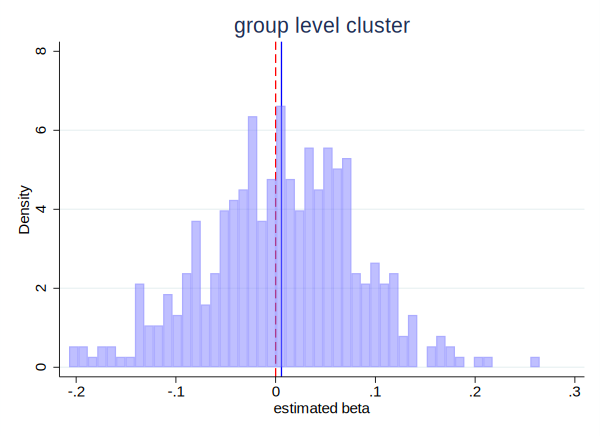

In [59]:
*(a) histogram of estimated beta
qui sum c1
local c1_mean = r(mean)
twoway hist c1, bin(50) xline(0, lc(red) lwidth(medium) lp(dash)) xline(`c1_mean', lc(blue) lwidth(medium)) ///
                lc(blue%10) fc(blue%50) fi(inten50) ///
                xti("estimated beta") title("group level cluster") graphregion(color(white))  //

##### (b) Histograms of auto-correlations

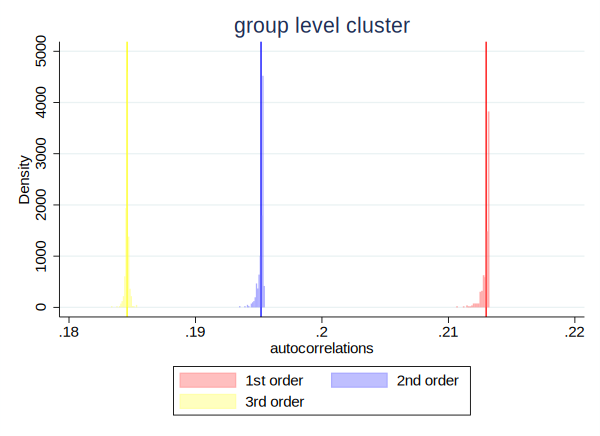

In [60]:
*(b) histograms of auto-correlations
qui sum c3
local c3_mean = r(mean)
qui sum c4
local c4_mean = r(mean)
qui sum c5
local c5_mean = r(mean)
twoway hist c3, xline(`c3_mean', lc(red) lwidth(medium)) lc(red%10) fc(red%50) fi(inten50) ///
    || hist c4, xline(`c4_mean', lc(blue) lwidth(medium)) lc(blue%10) fc(blue%50) fi(inten50)  ///
    || hist c5, xline(`c5_mean', lc(yellow) lwidth(medium)) lc(yellow%10) fc(yellow%50) fi(inten50) ///
       xti("autocorrelations")  title("group level cluster")  graphregion(color(white)) legend(order(1 "1st order" 2 "2nd order" 3 "3rd order"))

#### (c) Rejection rate

In [61]:
qui g tstat = c1/c2
qui sum tstat if tstat>1.96
scalar rej_rate = r(N)/$N
disp("Rejection rate:")
disp(rej_rate)





Rejection rate:

.0325


### OLS estimates with a small number of clusters
#### Individual level

In [81]:
global N = 400
matrix Result = J($N, 5, .) //matrix to store the results
use simdata_sub.dta,clear
set seed 12345
forv i = 1/$N {
   //disp("Processing `i'-th experiment...")
   cap drop grnum gt year treat ehat
   qui g grnum=.
   forv j = 1/60 {
        scalar r = runiform(0,1)
        qui replace grnum = r if g == `j' //group-specific random number
    }
    egen gt = cut(grnum), group(3)  //randomly assign them into two groups
    qui replace gt = (gt>1)  // group 2 to be treated
    scalar treat_year = runiform(2013, 2016)
    qui{
        g year = (t>=treat_year) 
        g treat = gt*year
        xtset id t
        reg y treat x i.g i.t, vce(cluster id)
        predict ehat,r
        forv l=1/3 {
            pwcorr ehat L`l'.ehat
            scalar corr`l' = r(rho)
        }
    }
        scalar b = _b[treat]
        scalar se = _se[treat]
        matrix Result[`i',1]=(b,se,corr1,corr2,corr3)
}






(46,290 real changes made)
(46,320 real changes made)
(46,580 real changes made)
(46,350 real changes made)
(46,510 real changes made)
(45,870 real changes made)
(46,820 real changes made)
(46,580 real changes made)
(46,580 real changes made)
(46,620 real changes made)
(46,900 real changes made)
(46,470 real changes made)
(46,960 real changes made)
(46,530 real changes made)
(46,070 real changes made)
(46,600 real changes made)
(46,580 real changes made)
(46,570 real changes made)
(46,810 real changes made)
(45,920 real changes made)
(46,610 real changes made)
(46,480 real changes made)
(46,720 real changes made)
(47,280 real changes made)
(46,350 real changes made)
(47,140 real changes made)
(46,310 real changes made)
(46,200 real changes made)
(46,150 real changes made)
(47,170 real changes made)
(46,610 real changes made)
(46,270 real changes made)
(46,700 real changes made)
(46,690 real changes made)
(46,910 real changes made)
(46,860 real changes made)
(46,700 real changes ma

In [82]:
drop _all
qui set obs $N
svmat double Result, names(c)
save Result1_sub.dta,replace




number of observations will be reset to 400
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 400

(note: file Result1_sub.dta not found)
file Result1_sub.dta saved


In [83]:
clear matrix

##### (a) Histogram of estimated $\beta$

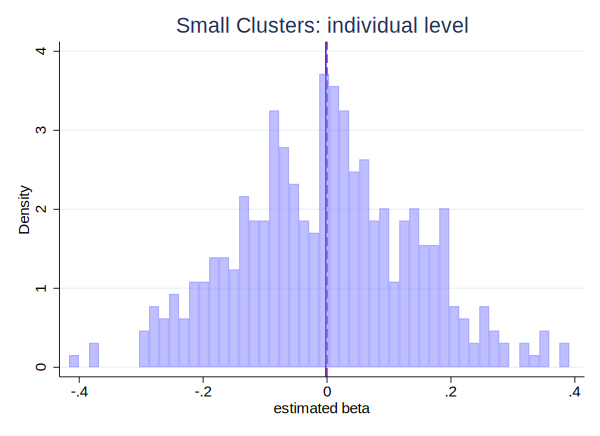

In [84]:
*(a) histogram of estimated beta
qui sum c1
local c1_mean = r(mean)
twoway hist c1, bin(50) xline(0, lc(red) lwidth(medium) lp(dash)) xline(`c1_mean', lc(blue) lwidth(medium)) ///
                lc(blue%10) fc(blue%50) fi(inten50) ///
                xti("estimated beta") title("Small Clusters: individual level") graphregion(color(white))  //

##### (b) Histograms of auto-correlations

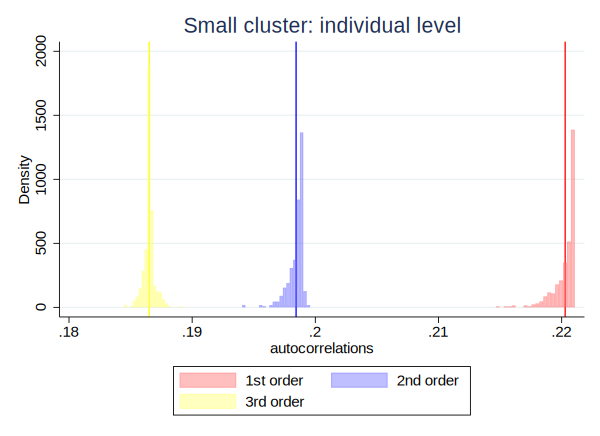

In [85]:
*(b) histograms of auto-correlations
qui sum c3
local c3_mean = r(mean)
qui sum c4
local c4_mean = r(mean)
qui sum c5
local c5_mean = r(mean)
twoway hist c3, xline(`c3_mean', lc(red) lwidth(medium)) lc(red%10) fc(red%50) fi(inten50) ///
    || hist c4, xline(`c4_mean', lc(blue) lwidth(medium)) lc(blue%10) fc(blue%50) fi(inten50)  ///
    || hist c5, xline(`c5_mean', lc(yellow) lwidth(medium)) lc(yellow%10) fc(yellow%50) fi(inten50) ///
       xti("autocorrelations")  title("Small cluster: individual level")  graphregion(color(white)) legend(order(1 "1st order" 2 "2nd order" 3 "3rd order"))

#### (c) Rejection rate

In [86]:
qui g tstat = c1/c2
qui sum tstat if tstat>1.96
scalar rej_rate = r(N)/$N
disp("Rejection rate:")
disp(rej_rate)





Rejection rate:

.3825


#### Cluster at Group-year Level

In [88]:
global N = 400
matrix Result = J($N, 5, .) //matrix to store the results
use simdata_sub.dta,clear
egen gr_t = group(g t)
set seed 12345
forv i = 1/$N {
   //disp("Processing `i'-th experiment...")
   cap drop grnum gt year treat ehat
   qui g grnum=.
   forv j = 1/60 {
        scalar r = runiform(0,1)
        qui replace grnum = r if g == `j' //group-specific random number
    }
    egen gt = cut(grnum), group(3)  //randomly assign them into two groups
    qui replace gt = (gt>1)  // group 2 to be treated
    scalar treat_year = runiform(2013, 2016)
    qui{
        g year = (t>=treat_year) 
        g treat = gt*year
        xtset id t
        reg y treat x i.g i.t, vce(cluster gr_t)
        predict ehat,r
        forv l=1/3 {
            pwcorr ehat L`l'.ehat
            scalar corr`l' = r(rho)
        }
    }
        scalar b = _b[treat]
        scalar se = _se[treat]
        matrix Result[`i',1]=(b,se,corr1,corr2,corr3)
}

In [89]:
drop _all
qui set obs $N
svmat double Result, names(c)
save Result2_sub.dta,replace




number of observations will be reset to 400
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 400

(note: file Result2_sub.dta not found)
file Result2_sub.dta saved


In [90]:
clear matrix

##### (a) Histogram of estimated $\beta$

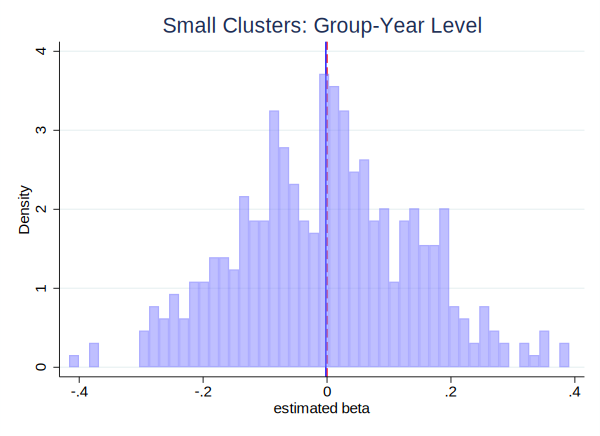

In [91]:
*(a) histogram of estimated beta
qui sum c1
local c1_mean = r(mean)
twoway hist c1, bin(50) xline(0, lc(red) lwidth(medium) lp(dash)) xline(`c1_mean', lc(blue) lwidth(medium)) ///
                lc(blue%10) fc(blue%50) fi(inten50) ///
                xti("estimated beta") title("Small Clusters: Group-Year Level") graphregion(color(white))  //

##### (b) Histograms of auto-correlations

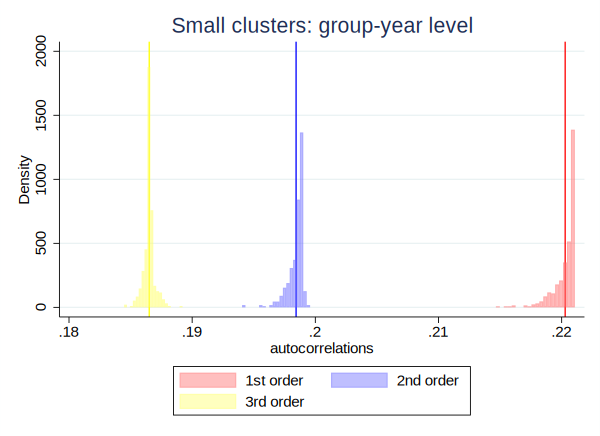

In [92]:
*(b) histograms of auto-correlations
qui sum c3
local c3_mean = r(mean)
qui sum c4
local c4_mean = r(mean)
qui sum c5
local c5_mean = r(mean)
twoway hist c3, xline(`c3_mean', lc(red) lwidth(medium)) lc(red%10) fc(red%50) fi(inten50) ///
    || hist c4, xline(`c4_mean', lc(blue) lwidth(medium)) lc(blue%10) fc(blue%50) fi(inten50)  ///
    || hist c5, xline(`c5_mean', lc(yellow) lwidth(medium)) lc(yellow%10) fc(yellow%50) fi(inten50) ///
       xti("autocorrelations")  title("Small clusters: group-year level")  graphregion(color(white)) legend(order(1 "1st order" 2 "2nd order" 3 "3rd order"))

#### (c) Rejection rate

In [93]:
qui g tstat = c1/c2
qui sum tstat if tstat>1.96
scalar rej_rate = r(N)/$N
disp("Rejection rate:")
disp(rej_rate)





Rejection rate:

.17


#### Cluster at Group Level

In [94]:
global N = 400
matrix Result = J($N, 5, .) //matrix to store the results
use simdata_sub.dta,clear
set seed 12345
forv i = 1/$N {
   //disp("Processing `i'-th experiment...")
   cap drop grnum gt year treat ehat
   qui g grnum=.
   forv j = 1/60 {
        scalar r = runiform(0,1)
        qui replace grnum = r if g == `j' //group-specific random number
    }
    egen gt = cut(grnum), group(3)  //randomly assign them into two groups
    qui replace gt = (gt>1)  // group 2 to be treated
    scalar treat_year = runiform(2013, 2016)
    qui{
        g year = (t>=treat_year) 
        g treat = gt*year
        xtset id t
        reg y treat x i.g i.t, vce(cluster g)
        predict ehat,r
        forv l=1/3 {
            pwcorr ehat L`l'.ehat
            scalar corr`l' = r(rho)
        }
    }
        scalar b = _b[treat]
        scalar se = _se[treat]
        matrix Result[`i',1]=(b,se,corr1,corr2,corr3)
}

In [95]:
drop _all
qui set obs $N
svmat double Result, names(c)
save Result3_sub.dta,replace




number of observations will be reset to 400
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 400

(note: file Result3_sub.dta not found)
file Result3_sub.dta saved


In [96]:
clear matrix

##### (a) Histogram of estimated $\beta$

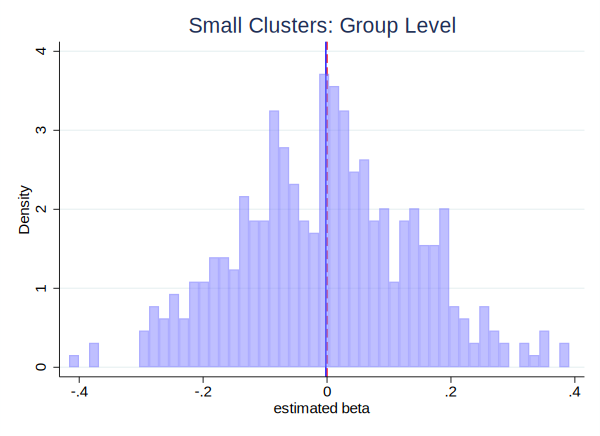

In [97]:
*(a) histogram of estimated beta
qui sum c1
local c1_mean = r(mean)
twoway hist c1, bin(50) xline(0, lc(red) lwidth(medium) lp(dash)) xline(`c1_mean', lc(blue) lwidth(medium)) ///
                lc(blue%10) fc(blue%50) fi(inten50) ///
                xti("estimated beta") title("Small Clusters: Group Level") graphregion(color(white))  //

##### (b) Histograms of auto-correlations

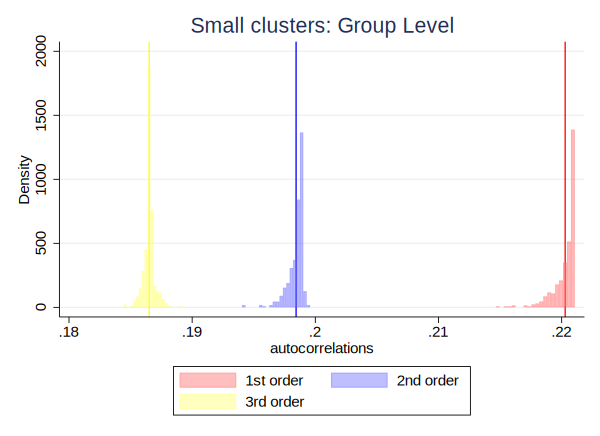

In [98]:
*(b) histograms of auto-correlations
qui sum c3
local c3_mean = r(mean)
qui sum c4
local c4_mean = r(mean)
qui sum c5
local c5_mean = r(mean)
twoway hist c3, xline(`c3_mean', lc(red) lwidth(medium)) lc(red%10) fc(red%50) fi(inten50) ///
    || hist c4, xline(`c4_mean', lc(blue) lwidth(medium)) lc(blue%10) fc(blue%50) fi(inten50)  ///
    || hist c5, xline(`c5_mean', lc(yellow) lwidth(medium)) lc(yellow%10) fc(yellow%50) fi(inten50) ///
       xti("autocorrelations")  title("Small clusters: Group Level")  graphregion(color(white)) legend(order(1 "1st order" 2 "2nd order" 3 "3rd order"))

#### (c) Rejection rate

In [99]:
qui g tstat = c1/c2
qui sum tstat if tstat>1.96
scalar rej_rate = r(N)/$N
disp("Rejection rate:")
disp(rej_rate)





Rejection rate:

.0325


### Monte Carlo Simulation for FE Estimates

#### Clustering at individual level

In [62]:
global N = 400
matrix Result = J($N, 5, .) //matrix to store the results
use simdata.dta,clear
egen gr_t = group(g t)
set seed 12345
forv i = 1/$N {
   //disp("Processing `i'-th experiment...")
   cap drop grnum gt year treat ehat
   qui g grnum=.
   forv j = 1/60 {
        scalar r = runiform(0,1)
        qui replace grnum = r if g == `j' //group-specific random number
    }
    egen gt = cut(grnum), group(2)  //randomly assign them into two groups
    scalar treat_year = runiform(2013, 2016)
    qui{
        g year = (t>=treat_year) 
        g treat = gt*year
        xtset id t
        xtreg y treat x i.t, fe vce(cluster id)
        predict ehat, e  // the pure error component
        forv l=1/3 {
            pwcorr ehat L`l'.ehat
            scalar corr`l' = r(rho)
        }
    }
        scalar b = _b[treat]
        scalar se = _se[treat]
        matrix Result[`i',1]=(b,se,corr1,corr2,corr3)
}

In [63]:
drop _all
qui set obs $N
svmat double Result, names(c)
save Result3.dta,replace
clear matrix




number of observations will be reset to 400
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 400

file Result2.dta saved



##### (a) Histogram of estimated $\beta$

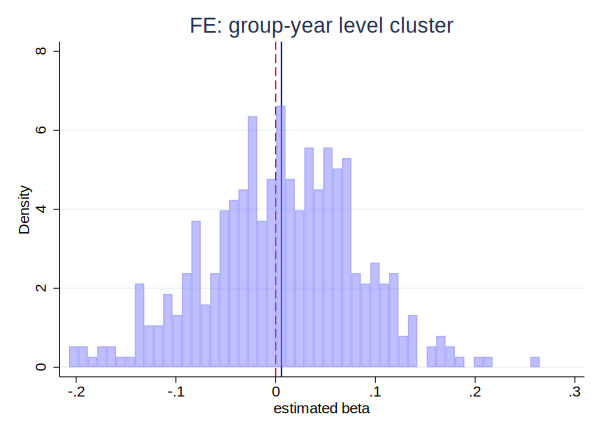

In [66]:
*(a) histogram of estimated beta
qui sum c1
local c1_mean = r(mean)
twoway hist c1, bin(50) xline(0, lc(red) lwidth(medium) lp(dash)) xline(`c1_mean', lc(blue) lwidth(medium)) ///
                lc(blue%10) fc(blue%50) fi(inten50) ///
                xti("estimated beta") title("FE: group-year level cluster") graphregion(color(white))

##### (b) Histograms of auto-correlations

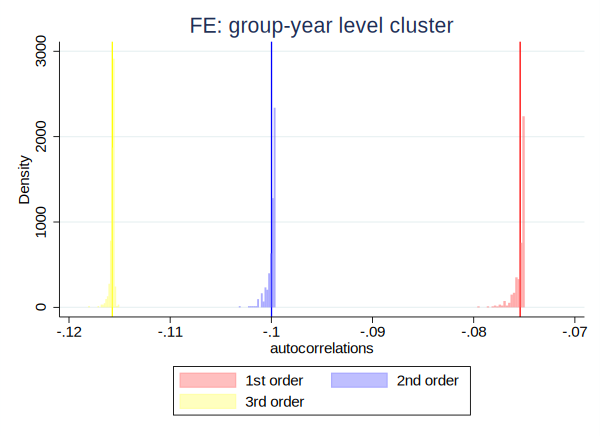

In [67]:
*(b) histograms of auto-correlations
qui sum c3
local c3_mean = r(mean)
qui sum c4
local c4_mean = r(mean)
qui sum c5
local c5_mean = r(mean)
twoway hist c3, xline(`c3_mean', lc(red) lwidth(medium)) lc(red%10) fc(red%50) fi(inten50) ///
    || hist c4, xline(`c4_mean', lc(blue) lwidth(medium)) lc(blue%10) fc(blue%50) fi(inten50)  ///
    || hist c5, xline(`c5_mean', lc(yellow) lwidth(medium)) lc(yellow%10) fc(yellow%50) fi(inten50) ///
       xti("autocorrelations")  title("FE: group-year level cluster")  graphregion(color(white)) legend(order(1 "1st order" 2 "2nd order" 3 "3rd order"))

#### (c) Rejection rate

In [68]:
qui g tstat = c1/c2
qui sum tstat if tstat>1.96
scalar rej_rate = r(N)/$N
disp("Rejection rate:")
disp(rej_rate)





Rejection rate:

.44


#### Clustering at group level

In [75]:
global N = 400
matrix Result = J($N, 5, .) //matrix to store the results
use simdata.dta,clear
set seed 12345
forv i = 1/$N {
   //disp("Processing `i'-th experiment...")
   cap drop grnum gt year treat ehat
   qui g grnum=.
   forv j = 1/60 {
        scalar r = runiform(0,1)
        qui replace grnum = r if g == `j' //group-specific random number
    }
    egen gt = cut(grnum), group(2)  //randomly assign them into two groups
    scalar treat_year = runiform(2013, 2016)
    qui{
        g year = (t>=treat_year) 
        g treat = gt*year
        xtset id t
        xtreg y treat x i.t, vce(cluster g)
        predict ehat, e 
        forv l=1/3 {
            pwcorr ehat L`l'.ehat
            scalar corr`l' = r(rho)
        }
    }
        scalar b = _b[treat]
        scalar se = _se[treat]
        matrix Result[`i',1]=(b,se,corr1,corr2,corr3)
}

In [77]:
drop _all
qui set obs $N
svmat double Result, names(c)
save Result5.dta,replace
clear matrix




number of observations will be reset to 400
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 400

(note: file Result5.dta not found)
file Result5.dta saved



##### (a) Histogram of estimated $\beta$

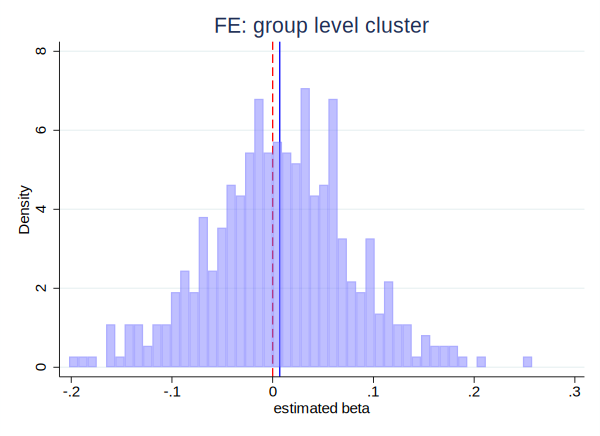

In [78]:
*(a) histogram of estimated beta
qui sum c1
local c1_mean = r(mean)
twoway hist c1, bin(50) xline(0, lc(red) lwidth(medium) lp(dash)) xline(`c1_mean', lc(blue) lwidth(medium)) ///
                lc(blue%10) fc(blue%50) fi(inten50) ///
                xti("estimated beta") title("FE: group level cluster") graphregion(color(white))  //

##### (b) Histograms of auto-correlations

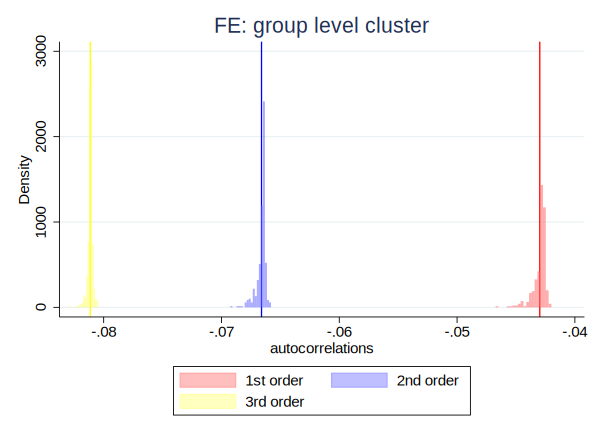

In [79]:
*(b) histograms of auto-correlations
qui sum c3
local c3_mean = r(mean)
qui sum c4
local c4_mean = r(mean)
qui sum c5
local c5_mean = r(mean)
twoway hist c3, xline(`c3_mean', lc(red) lwidth(medium)) lc(red%10) fc(red%50) fi(inten50) ///
    || hist c4, xline(`c4_mean', lc(blue) lwidth(medium)) lc(blue%10) fc(blue%50) fi(inten50)  ///
    || hist c5, xline(`c5_mean', lc(yellow) lwidth(medium)) lc(yellow%10) fc(yellow%50) fi(inten50) ///
       xti("autocorrelations")  title("FE: group level cluster")  graphregion(color(white)) legend(order(1 "1st order" 2 "2nd order" 3 "3rd order"))

#### (c) Rejection rate

In [80]:
qui g tstat = c1/c2
qui sum tstat if tstat>1.96
scalar rej_rate = r(N)/$N
disp("Rejection rate:")
disp(rej_rate)





Rejection rate:

.04


We can summarize the results for rejection rate as below:

|Level of cluster|OLS|FE |
|:---            |:--|:--|
|Individual      | 44%  | 44%   |
|Group-year      | 16.7%  | n.a.  |
|Group           | 3.25%  |  4% |

When we cluster at higher levels, we take the serial correlation among errors into consideration, which gives us more reliable standard errors and allows to do valid inference. 